In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# Dùng thư viện yfinance để tải dataset 
import yfinance as yf

In [26]:
df = pd.read_csv('BTC-USD.csv')

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/1/2019,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4.324201e+09
1,1/2/2019,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5.244857e+09
2,1/3/2019,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4.530215e+09
3,1/4/2019,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4.847965e+09
4,1/5/2019,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5.137610e+09


In [28]:
df = df[['Date', 'Close']]
df = df.dropna() # Drop missing values
# df = df.reset_index(drop=True) # Reset the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
print(df)

                   Close
Date                    
2019-01-01   3843.520020
2019-01-02   3943.409424
2019-01-03   3836.741211
2019-01-04   3857.717529
2019-01-05   3845.194580
...                  ...
2023-03-27  27139.888670
2023-03-28  27268.130860
2023-03-29  28348.441410
2023-03-30  28033.562500
2023-03-31  28478.484380

[1551 rows x 1 columns]


In [29]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
print(x_train)
y_train = np.array(train_data['Close'])
print(y_train)

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

[['2019-01-01T00:00:00.000000000']
 ['2019-01-02T00:00:00.000000000']
 ['2019-01-03T00:00:00.000000000']
 ...
 ['2021-12-18T00:00:00.000000000']
 ['2021-12-19T00:00:00.000000000']
 ['2021-12-20T00:00:00.000000000']]
[ 3843.52002   3943.409424  3836.741211 ... 46848.77734  46707.01563
 46880.27734 ]
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=18326.915, Time=6.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18334.592, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18334.396, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18334.415, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18333.913, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18338.414, Time=1.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=18338.402, Time=0.49 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=18328.615, Time=6.00 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=18328.727, Time=4.98 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18336.402, T

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

In [31]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [34]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
# last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
next_30_days_index = pd.date_range(start=last_index, periods=30, freq='D')

# Create an array of 30 consecutive integers starting from last_index
# x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
x_next_30_days = np.array(next_30_days_index).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days)) 

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[47060.44417267 47306.98002779 47400.43473151 47291.38944196
 47143.01338451 47150.91932063 47338.58897684 47541.82894864
 47588.7019632  47478.27760966 47372.84103744 47421.193624
 47604.98856781 47766.32126954 47778.67322624 47676.54524514
 47611.42399726 47688.65137721 47860.51395819 47983.57437329
 47972.36352013 47885.07121031 47855.82855524 47951.6823126
 48106.48091938 48196.31536423 48171.010131   48102.39579621
 48103.5502947  48209.38868512]


Validation RMSE: 29593.898784807752
Testing RMSE: 25612.570333202642


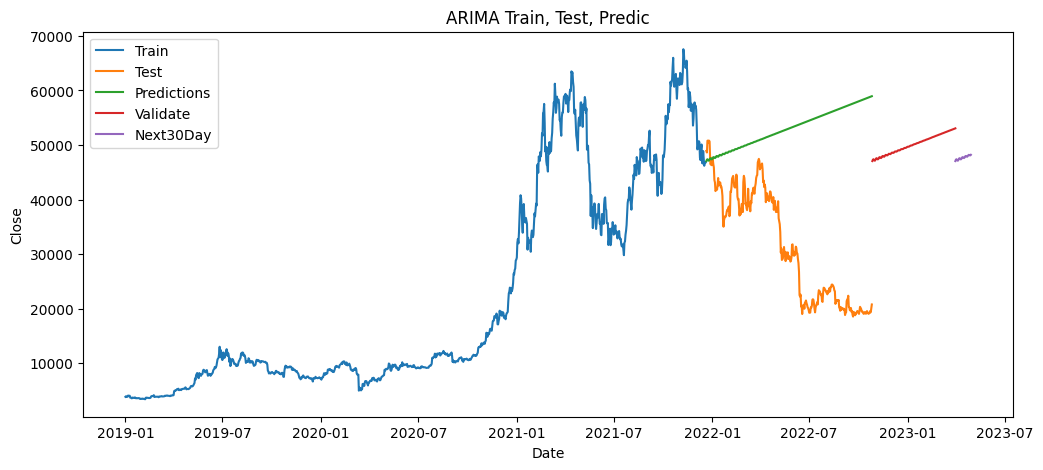

In [38]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Close');
plt.xlabel('Date');
plt.title('ARIMA Train, Test, Predic')
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
# plt.plot(last_data,y_next_30_days)
plt.plot(next_30_days_index,y_next_30_days)

plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()